In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3,MobileNet
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.models import load_model



In [2]:

# Define data directories
train_dir = 'catagories/train/'
validation_dir = 'catagories/validation/'
test_dir = 'catagories/test'


In [3]:
# Set batch size
batch_size = 32

inputShape=(224, 224, 3)

# Load pre-trained model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=inputShape)

# Freeze the base model
base_model.trainable = False


2024-04-09 17:56:32.617001: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-09 17:56:32.617023: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-09 17:56:32.617028: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-09 17:56:32.617217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 17:56:32.617238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='softmax')(x)



In [5]:
# Preprocess images and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'])  # Update with your class names

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'])  # Update with your class names



Found 1137 images belonging to 4 classes.
Found 243 images belonging to 4 classes.


In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/10


2024-04-09 17:56:36.996605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 21.3135 - accuracy: 0.6480

2024-04-09 17:57:42.653866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 80s 2s/step - loss: 21.3135 - accuracy: 0.6480 - val_loss: 6.0487 - val_accuracy: 0.8482
Epoch 2/10
35/35 [==============================] - 76s 2s/step - loss: 2.4196 - accuracy: 0.8362 - val_loss: 1.7968 - val_accuracy: 0.8661
Epoch 3/10
35/35 [==============================] - 76s 2s/step - loss: 1.8991 - accuracy: 0.8244 - val_loss: 1.0599 - val_accuracy: 0.8839
Epoch 4/10
35/35 [==============================] - 76s 2s/step - loss: 1.1600 - accuracy: 0.8597 - val_loss: 1.1328 - val_accuracy: 0.9107
Epoch 5/10
35/35 [==============================] - 77s 2s/step - loss: 1.2080 - accuracy: 0.8543 - val_loss: 1.1546 - val_accuracy: 0.9018
Epoch 6/10
35/35 [==============================] - 76s 2s/step - loss: 1.0896 - accuracy: 0.8579 - val_loss: 1.3875 - val_accuracy: 0.7321
Epoch 7/10
35/35 [==============================] - 76s 2s/step - loss: 1.4295 - accuracy: 0.8362 - val_loss: 1.0907 - val_accuracy: 0.9018
Epoch 8/10
35/35 [============

In [9]:
# Evaluate the model on test data
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['docks', 'object', 'persons', 'place'],  # Update with your class names
    shuffle=False)


Found 248 images belonging to 4 classes.


In [10]:
test_loss, test_acc = model.evaluate(test_generator,verbose=0)
print("Test accuracy:", test_acc)

Test accuracy: 0.8588709831237793


In [11]:
model.save('resnet50_model.h5')

/Users/dheemankumar/github/pc-clener/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy (ResNet50)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss (ResNet50)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


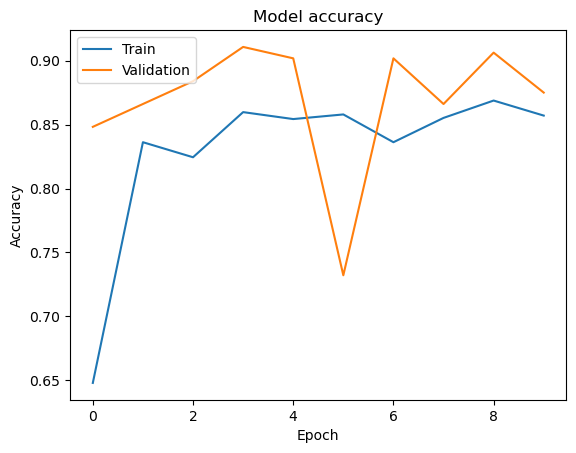

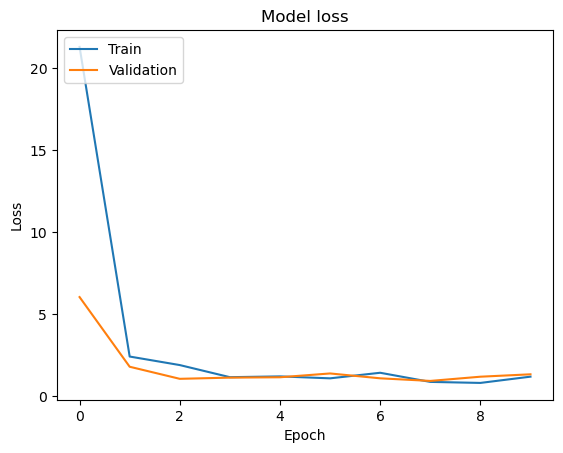

In [13]:
plot_history(history)